# Deep Learning Fall 2018 Project on HAM10000 Dataset

Data Source: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/DBW86T

(Tschandl, P., Rosendahl, C. & Kittler, H. The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. Sci. Data 5, 180161 (2018). doi: 10.1038/sdata.2018.161)

Cases include a representative collection of 7 important diagnostic categories in the realm of pigmented lesions: 
* Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec)
* basal cell carcinoma (bcc) 
* benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl)
* dermatofibroma (df) 
* melanoma (mel) 
* melanocytic nevi (nv) 
* vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc)


##  First we will import our libraries necessary to perform the initial exploration of the dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

base_skin_dir = os.path.join('..', 'input')
print(os.listdir("../input"))

Using TensorFlow backend.


['hmnist_28_28_L.csv', 'HAM10000_metadata.csv', 'hmnist_8_8_RGB.csv', 'hmnist_28_28_RGB.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_8_8_L.csv']


In [2]:
# Now we'll use glob to get the images in our base skin directory and then categorize them

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Creating our dictionary 
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'dermatofibroma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [3]:
# Now we're going to take a look at what our data looks like, as well as show the path. cell type and 
# categorized cell type (0-6) for the sample set using pandas

data = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
data['path'] = data['image_id'].map(imageid_path_dict.get)
data['cell_type'] = data['dx'].map(lesion_type_dict.get)
data['cell_type_idx'] = pd.Categorical(data['cell_type']).codes
data.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
5659,HAM_0005602,ISIC_0027532,nv,follow_up,30.0,male,trunk,../input/ham10000_images_part_1/ISIC_0027532.jpg,Melanocytic nevi,4
2060,HAM_0000952,ISIC_0024546,mel,histo,80.0,female,lower extremity,../input/ham10000_images_part_1/ISIC_0024546.jpg,dermatofibroma,6
4214,HAM_0006862,ISIC_0025296,nv,follow_up,50.0,female,trunk,../input/ham10000_images_part_1/ISIC_0025296.jpg,Melanocytic nevi,4
3364,HAM_0001307,ISIC_0025041,nv,follow_up,55.0,male,abdomen,../input/ham10000_images_part_1/ISIC_0025041.jpg,Melanocytic nevi,4
4786,HAM_0003954,ISIC_0031382,nv,follow_up,45.0,female,genital,../input/ham10000_images_part_2/ISIC_0031382.jpg,Melanocytic nevi,4


Above we are able to see several features of the sample data, one of which being the diagnosis given, another being the type of diagnosis given. More than 50% of the lesions are confirmed through histology (hist), the ground truth for the rest of these cases is either a follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal)

In [4]:
data.describe(exclude=np.number)

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0001863,ISIC_0032939,nv,histo,male,back,../input/ham10000_images_part_2/ISIC_0030641.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


In [5]:
data.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

Here it appears age has quite a few variables missing, so we'll fix this by filling it in with the average age...

In [6]:
data['age'].fillna((data['age'].mean()), inplace=True)

From the above table describing our data, we see that the most common diagnosis is Melanocytic nevi, which are benign neoplasms or hamartomas composed of melanocytes. We also observe that the most common sex to recieve a diagnosis are males, and the most common place to observe a skin lesion is on the back, diagnosed via a histopathology. We also observe that there are indeed 7 classes and 4 types in which a class can be diagnosed in our data set.

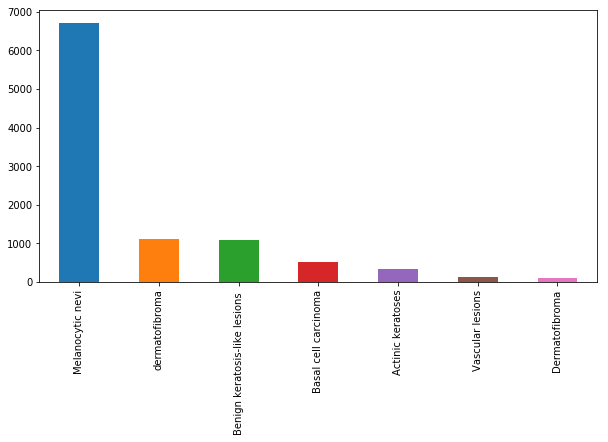

In [7]:
fig, ax1 = plt.subplots(1,1,figsize = (10, 5))
data['cell_type'].value_counts().plot(kind='bar', ax=ax1)

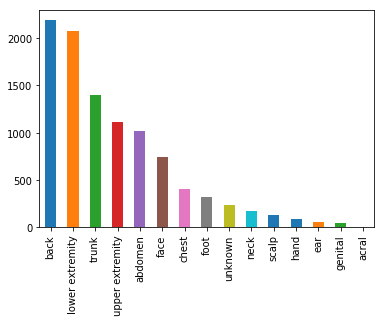

In [8]:
data['localization'].value_counts().plot(kind='bar')

Here we see that the two most common spots where skin lesions were identified were the back area and lower extremities.

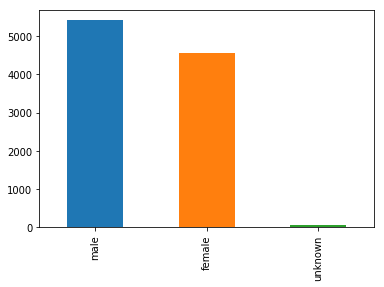

In [9]:
data['sex'].value_counts().plot(kind='bar')

Here we generate another plot to see the ratio of males to females who's lesions were observed.

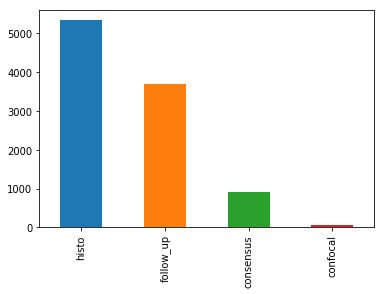

In [10]:
data['dx_type'].value_counts().plot(kind='bar')

Here we see the distribution of the validation field in which we see that most diagnosis were confirmed using a histopathology by a specialized dermatopathologist or by 3 follow up visits over a 1.5 year period in which digital dermatoscopy did not show any changes.

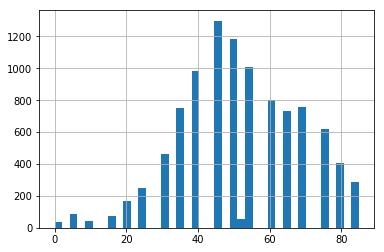

In [11]:
data['age'].hist(bins=40)

Here we see that that the average age for the dataset is between 35 and 55 years old.

## Loading and resizing our images 

Here we load in our data and resize our images from their original dimensions of 450x600x3 to 100x75, which will allow our model to train considerably faster.

In [12]:
# load and resize all of the images
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [13]:
# check to see the new image size distribution 

data['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

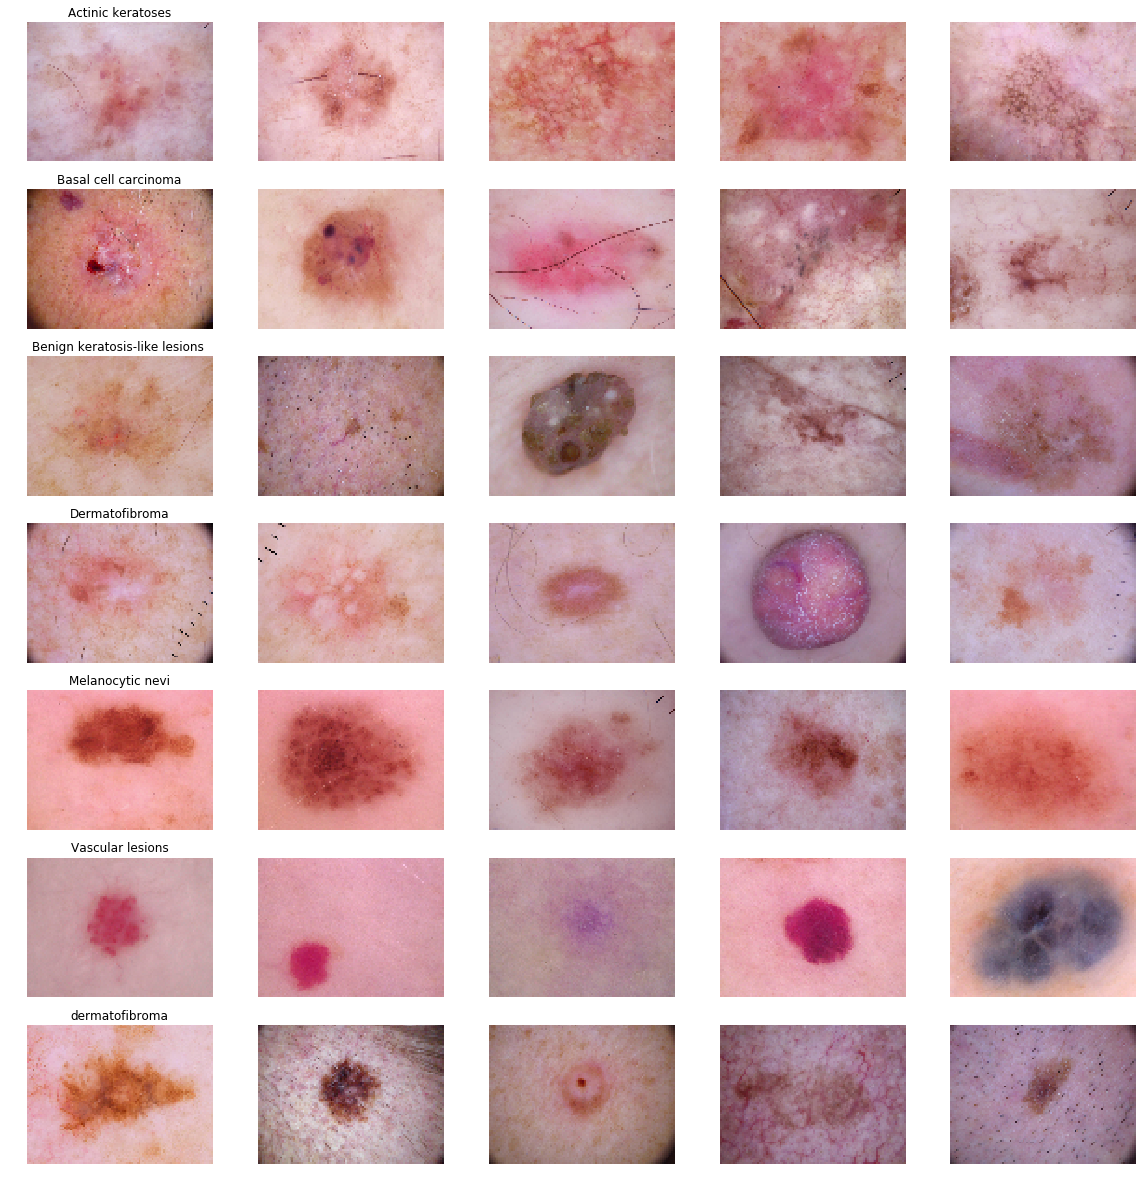

In [14]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         data.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [15]:
# and finally we will set up the features for our model as well as the target we want to classify

X = data.drop(columns=['cell_type_idx'],axis=1)
Y = data['cell_type_idx']

## Splitting and normalizing our training and validation sets

In [16]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(X, Y, test_size=0.2, random_state=1234)

x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

# now we'll get the mean and std dev to normalize

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

# now the normalized datasets

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [17]:
# set our target Y to be a categorical 1-7

y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8012, 75, 100, 3)
(8012, 7)
(2003, 75, 100, 3)
(2003, 7)


In [19]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [20]:
# reshape our images to 3 dimensions for our model

x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [21]:
# now we create our model

input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
__________

In [22]:
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [23]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [26]:
epochs = 50 
batch_size = 10
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs=epochs, validation_data=(x_test,y_test),
                              verbose=1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
721/721 [==============================] - 30s 42ms/step - loss: 1.0313 - acc: 0.6657 - val_loss: 1.0118 - val_acc: 0.6590
Epoch 2/50
721/721 [==============================] - 24s 34ms/step - loss: 0.9226 - acc: 0.6712 - val_loss: 0.8561 - val_acc: 0.6680
Epoch 3/50
721/721 [==============================] - 24s 34ms/step - loss: 0.8909 - acc: 0.6748 - val_loss: 0.8863 - val_acc: 0.6830
Epoch 4/50
721/721 [==============================] - 24s 34ms/step - loss: 0.8645 - acc: 0.6845 - val_loss: 0.8464 - val_acc: 0.6910
Epoch 5/50
721/721 [==============================] - 25s 35ms/step - loss: 0.8380 - acc: 0.6951 - val_loss: 0.7682 - val_acc: 0.7000
Epoch 6/50
721/721 [==============================] - 25s 34ms/step - loss: 0.8179 - acc: 0.7024 - val_loss: 0.7468 - val_acc: 0.7179
Epoch 7/50
721/721 [==============================] - 25s 34ms/step - loss: 0.8051 - acc: 0.7098 - val_loss: 0.7613 - val_acc: 0.7174
Epoch 8/50
721/721 [==============================] - 24s 34ms

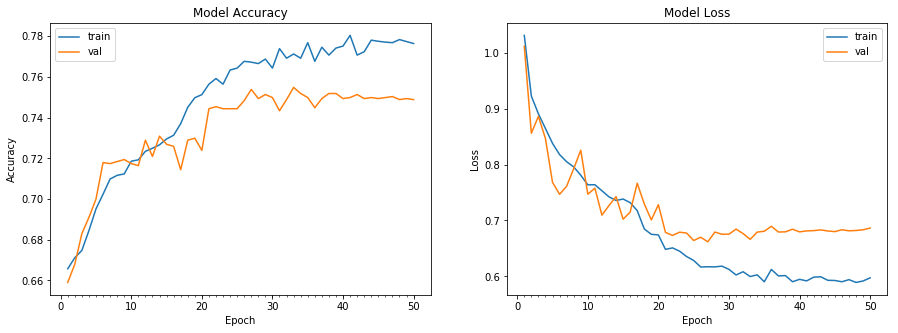

In [27]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()
    
plot_model_history(history)

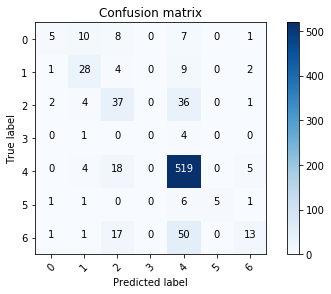

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 